In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from deepchem import metrics
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.model_selection import GridSearchCV


In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [3]:
X = bbb_df.drop(columns=["Drug", "SMILES", 'permeable'])
Y = bbb_df['permeable']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Optimized SVM

In [4]:
SVM_best = SVC(C=0.1, gamma=1, kernel='linear', probability=True).fit(X_train, y_train)

## Scaffold Split

In [5]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

## Model Training and Predictions

In [6]:
# Train Decision Tree classifier
SVM_best = SVM_best.fit(train_scaff.X,train_scaff.y)

In [7]:
# Predict the response for test dataset
y_pred_scaff = SVM_best.predict(test_scaff.X)

In [8]:
y_pred_scaff_prob = SVM_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
149,Clc1ccc(c(c1)Cl)/C(/Cl)=C/n1cncn1,0.999999
124,O=C(N1CCN(CC1)Cc1ccccc1)c1oc2ccccc2c1,0.999999
305,CCCCc1nc(c(n1Cc1ccc(cc1)c1ccccc1c1[nH]nnn1)CO)Cl,0.999999
150,Nc1nnc(c(n1)N)c1cccc(c1Cl)Cl,0.999998
63,CCN1CCC(C1)=C(c1ccccc1)c1ccccc1,0.999998
...,...,...
244,CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000175
185,COC(=O)C1NC(=O)[C@H]2NC(=O)[C@H](NC(=O)[C@@H]3...,0.000151
184,CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(c(c2...,0.000070
270,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000048


## Feature Importances

In [9]:
# get importance
dt_importance = SVM_best.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance[0]) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[0][i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [10]:
feature_importance

,Feature,Importance
5,5,-0.349273
346,357,-0.331275
399,410,-0.258262
306,315,-0.256448
624,640,-0.254354
...,...,...
564,580,0.172304
75,78,0.176783
516,530,0.183104
132,138,0.187629


Text(0.5, 1.0, 'Top 10 SVM Feature Importances')

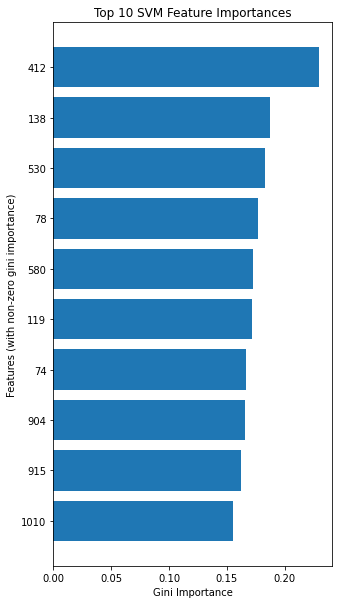

In [11]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 SVM Feature Importances')

In [15]:
important_features = feature_importance['Feature'].values.astype(int)
important_features[-20:]

array([ 835,  935,  667,  245,  672,  520,  155,  144,  249,  646, 1010,
        915,  904,   74,  119,  580,   78,  530,  138,  412])